Welcome to the 30 minutes Flower federated learning tutorial!

In this tutorial you will implement your first Federated Learning project using [Flower](https://flower.ai/).

🧑‍🏫 This tutorial starts at zero and expects no familiarity with federated learning. Only a basic understanding of data science and Python programming is assumed. A minimal understanding of ML is not required but if you already know about it, nothing is stopping your from modifying this code as you see fit!

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Flower Discuss and the Flower Slack to connect, ask questions, and get help:
> - [Join Flower Discuss](https://discuss.flower.ai/) We'd love to hear from you in the `Introduction` topic! If anything is unclear, post in `Flower Help - Beginners`.
> - [Join Flower Slack](https://flower.ai/join-slack) We'd love to hear from you in the `#introductions` channel! If anything is unclear, head over to the `#questions` channel.

Let's get started!

## Complementary Content

But before do so, let me point you to a few video tutorials in the [Flower Youtube channel](https://www.youtube.com/@flowerlabs) that you might want to check out after this tutorial. We post new videos fairly regularly with new content:
* **[VIDEO]** quickstart-tensorflow: [15-min video on how to start with Flower + Tensorflow/Keras](https://www.youtube.com/watch?v=FGTc2TQq7VM)
* **[VIDEO]** quickstart-pytorch: [20-min video on how to start with Flower + PyTorch](https://www.youtube.com/watch?v=jOmmuzMIQ4c)
* **[VIDEO]**  Flower simulation mini-series: [9 line-by-line video tutorials](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB)

# Environment Setup

Now let's really begin with this tutorial!

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab. Let's first, install Flower, then the ML framework of your choice and extra dependencies you might want to use.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr-nightly[simulation] flwr-datasets

zsh:1: no matches found: flwr-nightly[simulation]


We will be using the _simulation_ model in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the `Virtual Client Engine`, the core component that runs [FL Simulations](https://flower.ai/docs/framework/how-to-run-simulations.html) with Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everything transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.

## Install your ML framework

Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart- example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory. And check the [Flower Documentation](https://flower.ai/docs/) for even more learning materials.

In this tutorial we are going to use PyTorch, so let's install a recent version. In this tutorial we'll use a small model so using CPU only training will suffice (this will also prevent Colab from abruptly terminating your experiment if resource limits are exceeded)

In [2]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
^C
ERROR: Operation cancelled by user


We are going to install some other dependencies you are likely familiar with. We'll use these to make plots.

In [ ]:
!pip install matplotlib

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset. We will use Flower Datasets to construct the dataset. For more information, read the documentation [here](https://flower.ai/docs/datasets/how-to-use-with-pytorch.html).

In [1]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from flwr_datasets import FederatedDataset


def get_mnist():
    """This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. We load the training and
    test splits in this function."""

    fds = FederatedDataset(dataset="mnist", partitioners={"train": 100})
    trainset = fds.load_split("train")
    testset = fds.load_split("test")

    return trainset, testset

Let's run the code above and do some visualisations to understand better the data we are working with !

In [2]:
trainset, testset = get_mnist()

/Users/danielnugraha/.pyenv/versions/3.10.13/envs/flower-3.10.13/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


We can have a quick overview of our datasets by just typing the object on the command line. For instance, below you can see that the `trainset` has 60k training examples and will use the transformation rule we defined above in `get_mnist()`.

In [ ]:
trainset

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

([<matplotlib.axis.XTick at 0x31c7e85e0>,
 [Text(8, 0, '8'),
  Text(7, 0, '7'),
  Text(1, 0, '1'),
  Text(6, 0, '6'),
  Text(0, 0, '0'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(2, 0, '2'),
  Text(9, 0, '9'),
  Text(5, 0, '5')])

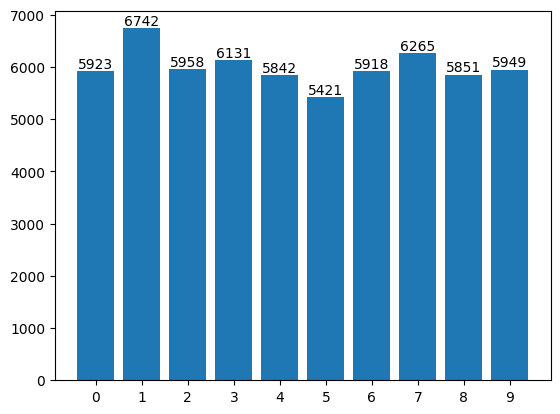

In [3]:
import matplotlib.pyplot as plt
from collections import Counter


# construct histogram
all_labels = trainset["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
plt.bar_label(bar)

# plot formatting
plt.xticks([label for label in all_label_counts.keys()])

Let's visualise 32 images from the dataset


In [4]:
import random
import numpy as np
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

will display images with idx: [275, 4872, 44316, 55668, 27662, 55263, 37089, 18900, 14967, 59225, 23795, 43412, 52243, 59471, 42071, 21064, 27967, 17162, 12583, 47693, 53171, 17128, 54377, 41541, 27529, 26283, 9160, 29349, 55772, 33729, 46857, 42455]


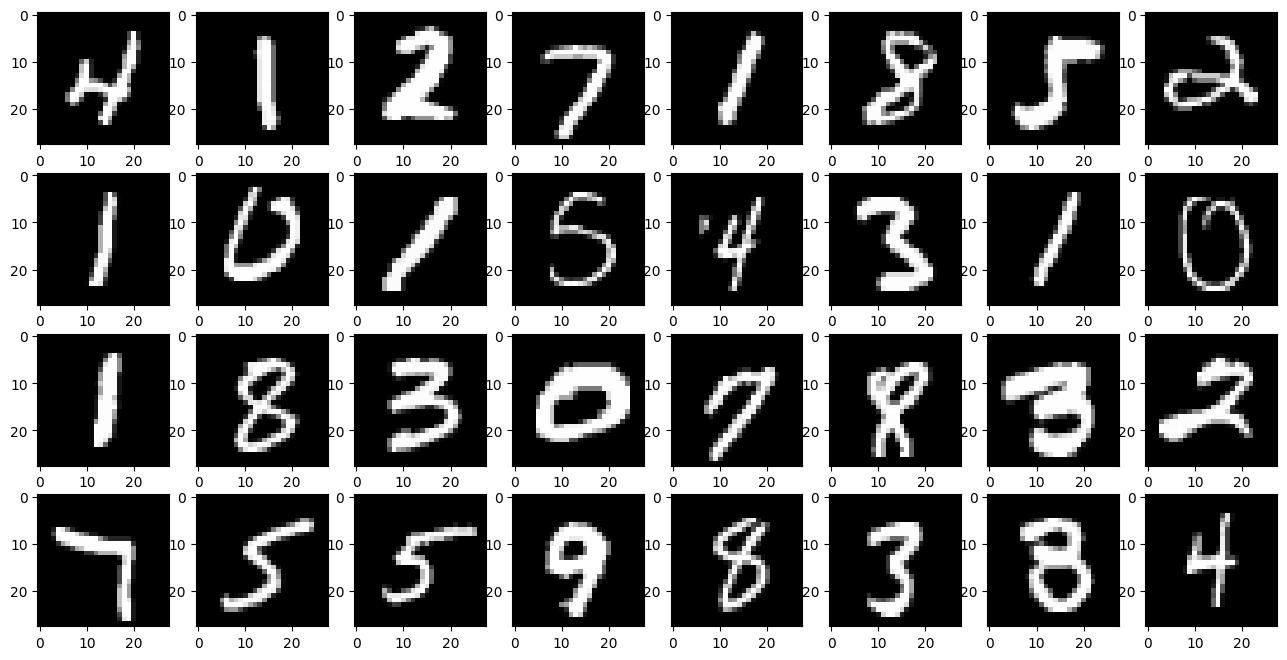

In [5]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

# A CNN architecture

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

In [7]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


In [8]:
from tqdm import tqdm


def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for batch in tqdm(trainloader, "Training"):
            images, labels = batch["image"], batch["label"]
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in tqdm(testloader, "Testing"):
            images, labels = batch["image"], batch["label"]
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist()

    # prepare train and test set
    # transformation to convert images to tensors and apply normalisation
    transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    train_torch = trainset.map(
        lambda image: {"image": transforms(image)}, input_columns="image"
    ).with_format("torch")
    test_torch = testset.map(
        lambda image: {"image": transforms(image)}, input_columns="image"
    ).with_format("torch")

    trainloader = DataLoader(train_torch, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(test_torch, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [11]:
run_centralised(epochs=5, lr=0.01)

/Users/danielnugraha/.pyenv/versions/3.10.13/envs/flower-3.10.13/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Testing: 100%|██████████| 79/79 [00:02<00:00, 34.39it/s]

loss = 3.333561828127131
accuracy = 0.9866


The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system, using Flower Datasets. Let's create 100 partitions and extract some statistics from one partition.

/Users/danielnugraha/.pyenv/versions/3.10.13/envs/flower-3.10.13/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


number of images: 540


([<matplotlib.axis.XTick at 0x3247c3490>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(3, 0, '3'),
  Text(9, 0, '9'),
  Text(0, 0, '0'),
  Text(6, 0, '6')])

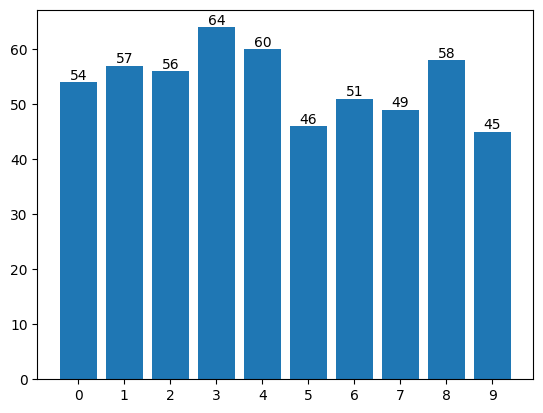

In [9]:
from flwr_datasets import FederatedDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

fds = FederatedDataset(dataset="mnist", partitioners={"train": 100})
test_dataset = fds.load_split("test")

partition = fds.load_partition(0, "train")
partition_train_test = partition.train_test_split(test_size=0.1, seed=42)
partition_train = partition_train_test["train"]

# count data points
labels = partition_train["label"]
print(f"number of images: {len(labels)}")
label_counts = Counter(labels)

# visualise histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
plt.bar_label(bar)
plt.xticks([label for label in label_counts.keys()])

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginning where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

Let's next define how our FL clients will behave

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

Now let's define our Flower Client class:

In [10]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(
            self.model, self.valloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking about the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Chosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be available in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

For the experiment, we will be using `FedAvgHistory`, an extension of `FedAvg` that outputs a plot of the evaluate results at the end of the experiment. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify the `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [18]:
from flwr.server.strategy import FedAvg
from flwr.common import Parameters
from typing import Optional

loss_list = []
metrics_list = []
num_rounds = 10

class FedAvgHistory(FedAvg):
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        loss, metrics = super().evaluate(server_round, parameters)
        loss_list.append(loss)
        metrics_list.append(metrics)
        if len(loss_list) == num_rounds + 1:
            round = list(range(1, len(loss_list) + 1))
            acc = [100.0 * metrics["accuracy"] for metrics in metrics_list]
            plt.plot(round, acc)
            plt.grid()
            plt.ylabel("Accuracy (%)")
            plt.xlabel("Round")
            plt.title("MNIST - IID - 100 clients with 10 clients per round")


def get_evaluate_fn(fds: FederatedDataset):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""
    testset = fds.load_split("test")
    transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    test_torch = testset.map(
        lambda image: {"image": transforms(image)}, input_columns="image"
    ).with_format("torch")

    testloader = DataLoader(test_torch, batch_size=128)

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = FedAvgHistory(
    fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    fraction_evaluate=0.1,  # after each round, let's sample 10% of the clients to asses how well the global model is doing
    min_available_clients=100,  # total number of clients available in the experiment
    evaluate_fn=get_evaluate_fn(fds),
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [12]:
from flwr.common import Context
from flwr.client import ClientApp
from torchvision.transforms import ToTensor


def generate_client_fn(fds: FederatedDataset):
    def client_fn(context: Context):
        """Returns a FlowerClient containing the data partition"""

        partition_id = int(context.node_config["partition-id"])
        partition = fds.load_partition(partition_id, "train")
        partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
        partition_train = partition_train_val["train"]
        partition_val = partition_train_val["test"]

        transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

        partition_train_torch = partition_train.map(
            lambda image: {"image": transforms(image)}, input_columns="image"
        ).with_format("torch")
        partition_val_torch = partition_val.map(
            lambda image: {"image": transforms(image)}, input_columns="image"
        ).with_format("torch")

        partition_val_dataloader = DataLoader(
            partition_val_torch, batch_size=32, shuffle=False, num_workers=2
        )
        partition_train_dataloader = DataLoader(
            partition_train_torch, batch_size=32, shuffle=False, num_workers=2
        )

        return FlowerClient(
            trainloader=partition_train_dataloader, valloader=partition_val_dataloader
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(fds)
client_app = ClientApp(client_fn=client_fn_callback)

Now we are ready to launch the FL experiment using Flower simulation.
Doing 10 rounds should take less than 2 minutes on a CPU-only Colab instance <-- Flower Simulation is fast! 🚀

Below you can see the plots of the centralised evaluation accuracy obtained at the end of each round (including at the very beginning of the experiment) for the _global model_. This is the function `evaluate_fn()` that we passed to the strategy reports.


            Check the following `FEATURE UPDATE` warning message for the preferred
            new mechanism to use this feature in Flower.
        
        ------------------------------------------------------------
        

        def server_fn(context: Context):
            server_config = ServerConfig(num_rounds=3)
            strategy = FedAvg()
            return ServerAppComponents(
                strategy=strategy,
                server_config=server_config,
        )

        app = ServerApp(server_fn=server_fn)

        ------------------------------------------------------------
        
INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
Testing: 100%|██████████| 79/79 [00:02<00:00, 35.18it/s]
INFO :      
INFO :      [ROUND 1]
INFO :   

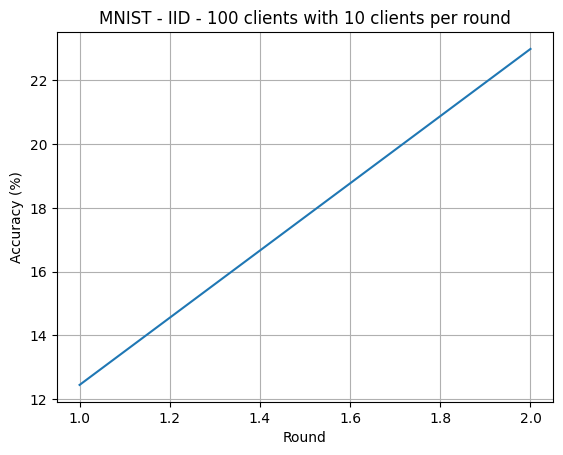

In [21]:
from flwr.server import ServerApp, LegacyContext, ServerConfig
from flwr.server.workflow import DefaultWorkflow
from flwr.simulation import run_simulation

server_app = ServerApp(
    config=ServerConfig(num_rounds=num_rounds), 
    strategy=strategy
)

run_simulation(server_app=server_app, client_app=client_app, num_supernodes=100)

## What's next?

Well, if you enjoyed this content, consider giving us a ⭐️ on GitHub -> https://github.com/adap/flower

* **[DOCS]** How about running your Flower clients on the GPU? find out how to do it in the [Flower Simulation Documentation](https://flower.ai/docs/framework/how-to-run-simulations.html)

* **[VIDEO]** You can follow our [detailed line-by-line 9-videos tutorial](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB) about everything you need to know to design your own Flower Simulation pipelines

* Check more advanced simulation examples the Flower GitHub:

    * Flower simulation with Tensorflow/Keras: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-tensorflow)

    * Flower simulation with Pytorch: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-pytorch)

* **[DOCS]** All Flower examples: https://flower.ai/docs/examples/

* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.ai/join-slack/
